## Preprocessing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.usetex = True
from tqdm.notebook import tqdm
import pickle

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
data, target = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True,
                            )
# data_samples = data[:n_samples]
data_samples = data

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=10000,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

In [ ]:
vocabulary = tf_vectorizer.vocabulary_

In [ ]:
vocabulary

{'sure': 8719,
 'story': 8583,
 'did': 3039,
 'biased': 1580,
 'disagree': 3087,
 'statement': 8519,
 'media': 5795,
 'reputation': 7609,
 'pro': 7078,
 'israeli': 5000,
 'world': 9794,
 'having': 4386,
 'lived': 5490,
 'europe': 3538,
 'realize': 7426,
 'described': 2960,
 'letter': 5398,
 'occured': 6360,
 'try': 9186,
 'ignore': 4649,
 'existance': 3603,
 'europeans': 3540,
 'degree': 2901,
 'think': 8965,
 'reason': 7430,
 'report': 7589,
 'clearly': 2191,
 'atrocities': 1327,
 'shame': 8149,
 'austria': 1361,
 'daily': 2775,
 'reports': 7594,
 'acts': 880,
 'soldiers': 8353,
 'received': 7444,
 'government': 4210,
 'makes': 5649,
 'holocaust': 4507,
 'guilt': 4296,
 'away': 1399,
 'look': 5532,
 'jews': 5058,
 'treating': 9144,
 'races': 7343,
 'got': 4205,
 'power': 6964,
 'unfortunate': 9304,
 'yeah': 9930,
 'expect': 3614,
 'people': 6701,
 'read': 7412,
 'faq': 3728,
 'actually': 882,
 'accept': 827,
 'hard': 4361,
 'atheism': 1313,
 'need': 6162,
 'little': 5487,
 'leap': 536

In [ ]:
docs = []
for row in tf.toarray():
    present_words = np.where(row != 0)[0].tolist()
    present_words_with_count = []
    for word_idx in present_words:
        for count in range(row[word_idx]):
            present_words_with_count.append(word_idx)
    docs.append(present_words_with_count)

In [ ]:
inv_vocabulary = {v: k for k, v in vocabulary.items()}

In [ ]:
data[0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [ ]:
for i in docs[0]:
  print(inv_vocabulary[i], end=" ")

acts atrocities austria away biased clearly daily degree described did disagree europe europeans existance got government guilt having holocaust ignore israeli israeli jews letter lived look makes media media media media occured power pro races realize reason received report reports reputation shame soldiers statement story sure think treating try unfortunate world 

In [ ]:
from sklearn import metrics

In [ ]:
def plot_confusion_matrix(plt, cm,
                          classes,
                          clusters,
                          title = ''):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    xtick_marks = np.arange(len(clusters))
    ytick_marks = np.arange(len(classes))
    plt.xticks(xtick_marks, clusters, rotation=45)
    plt.yticks(ytick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [ ]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

## LDA using custom functions

### Gibbs sampling

In [ ]:
M = len(docs)  # number of documents in the collection
N = len(vocabulary)  # number of words in the collection
K = 20  # number of topics

z = np.zeros(shape=(N))  # topic assignment for each word
n_d_k = np.zeros(shape=(M, K))  # Number of times document d uses topic k
n_k_w = np.zeros(shape=(K, N))  # Number of times topic k uses word type wd,n

beta = 1 / K         # the parameter of the Dirichlet prior on the per-document topic distributions
alpha = 1 / K        # the parameter of the Dirichlet prior on the per-topic word distribution

In [ ]:
z = []
for ind in tqdm(range(1)):
  for docIdx, doc in enumerate(docs):
    # print(doc)
    z_d = []
    for wordIdx in doc:
      topicIdx = len(doc) % K
      z_d.append(topicIdx)
      n_d_k[docIdx][topicIdx] += 1
      n_k_w[topicIdx][wordIdx] += 1
    z.append(z_d)

In [ ]:
for iter in tqdm(range(10)):
  for docIdx, doc in enumerate(docs):
    # print("Initial n_d_k", n_d_k[docIdx])
    for w, wordIdx in enumerate(doc):
        # Fetch topic of the word
        topicIdx = z[docIdx][w]

        # Decrement counters corresponding to this word
        n_d_k[docIdx][topicIdx] -= 1
        n_k_w[topicIdx][wordIdx] -= 1


        p_d_k = (n_d_k[docIdx] + alpha) / (np.sum(n_d_k) + K * alpha)
        p_k_w = (n_k_w[:, wordIdx] + beta) / (np.sum(n_k_w) + N*beta)
        p_z = p_d_k * p_k_w
        p_z = p_z / np.sum(p_z)
        # print(p_z)

        newTopicIdx = np.random.multinomial(1, p_z).argmax()
        z[docIdx][w] = newTopicIdx

        # Increment counters corresponding to this word
        n_d_k[docIdx][newTopicIdx] += 1
        n_k_w[newTopicIdx][wordIdx] += 1
      # print("Final n_d_k", n_d_k[docIdx])

In [ ]:
def plot_topic_dist(word):
  ind = np.where(np.asarray(list(vocabulary.keys()))==word)[0][0]
  vInd = list(vocabulary.values())[ind]
  vWord = list(vocabulary.keys())[ind]
  plt.plot(range(20), n_k_w.T[ind]/ sum(n_k_w.T[ind]))
  plt.title("Topic distribution for word: '{}'".format(vWord))
  plt.xticks(range(20))
  plt.show()

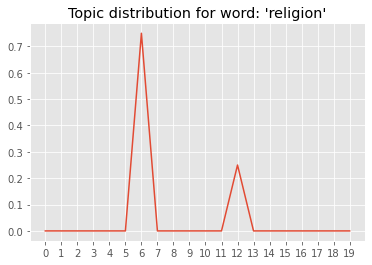

In [ ]:
plot_topic_dist("religion")

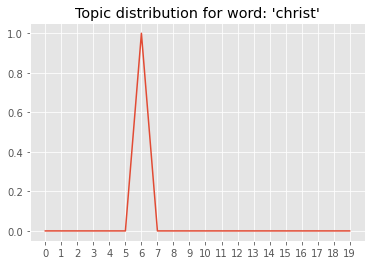

In [ ]:
plot_topic_dist("christ")

In [ ]:
n_top_words = 10
for topic_idx, topic in enumerate(n_k_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: w7 uw t7 chz cx ck w1 hz a7 lk
Topic #1: people don know said just like think did say right
Topic #2: chastity geb dsl n3jxp shameful cadre intellect skepticism pitt gordon
Topic #3: astronaut larson directive bobbe unified 70s physicists catcher queens pitched
Topic #4: db mov bh si byte bl di al cs cx
Topic #5: cx c_ s6 ck hz lk chz sc_ w7 17
Topic #6: like use edu just don know new does 10 time
Topic #7: dod polio dole dee ax bolshevik 1d9 3t 9v chastity
Topic #8: zz edition edu edt edmonton edm editors editorial editor editing
Topic #9: ax max g9v b8f a86 pl 1d9 3t 145 1t
Topic #10: armenian armenians jews azerbaijan turkish don ottoman did dod armenia
Topic #11: ax b8f 145 max a86 0t pl 34u 1t ah
Topic #12: people just don like think know time use does god
Topic #13: spine inference cmap 1948 1964 docs editorial edu edt edmonton
Topic #14: cubs suck hiv vaccines infectious hampshire clinical fundamentalists billboard protest
Topic #15: ax max 75u 2di 145 0d 34u sl b8f bh

In [ ]:
predLabels = []
for i in n_d_k:
  predLabels.append(np.argmax(i))

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/predLabels_Gibbs_custom.pkl', 'wb') as f:
  pickle.dump(predLabels, f)

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/predLabels_Gibbs_custom.pkl','rb')
predLabels = pickle.load(file)
file.close()

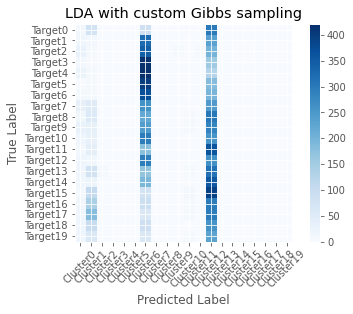

In [ ]:
clusterNames = ["Cluster%d" % i for i in range(20)]
targetNames = ["Target%d" % i for i in range(20)]
cm = metrics.confusion_matrix(target, predLabels)
plt.figure()
plot_confusion_matrix(plt, cm,
                       classes=targetNames,
                       clusters=clusterNames,
                       title='LDA with custom Gibbs sampling')

In [ ]:
print("LDA with custom Gibbs sampling")
print("Homogeneity", metrics.homogeneity_score(target, predLabels))
print("Completenesee", metrics.completeness_score(target, predLabels))
print("Normalized Mutual Information", metrics.normalized_mutual_info_score(target, predLabels))
print("Purity", purity_score(target, predLabels))

LDA with custom Gibbs sampling
Homogeneity 0.04063416533673405
Completenesee 0.11067726730802309
Normalized Mutual Information 0.05944399970583384
Purity 0.09395439278769666


### Variational inference

In [ ]:
from scipy.special import digamma, polygamma

In [ ]:
import toolz as tz
import toolz.curried as c
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
part = 1000
d_sub = docs[:part]

In [ ]:
tf = {id: tz.frequencies(doc) for id, doc in enumerate(d_sub)}
df = pd.DataFrame(tf).fillna(0)
words = df.index

ds = df.values.T
ds = ds.astype(int)

def DataTrans(x):
    """Turn the data into the desired structure"""
    
    N_d = np.count_nonzero(x)
    V = len(x)
    
    row = 0
    
    doc = np.zeros((N_d, V))
    for i in range(V):
        if x[i] == 0:
            pass
        else:
            doc[row, i] = x[i]
            row += 1
    
    return doc

docsTransformed = list(map(DataTrans, ds))

In [ ]:
# docs = docsTransformed
M = len(docsTransformed)
V = docsTransformed[1].shape[1]
N = [doc.shape[0] for doc in docsTransformed]
K = 20

initial_alpha_shape = 100
initial_alpha_scale = 0.01

print("M", M)
print("V", V)
print("N", N)

M 1000
V 7930
N [47, 38, 35, 62, 31, 16, 114, 40, 27, 56, 1514, 19, 18, 37, 8, 10, 47, 18, 10, 98, 37, 48, 35, 39, 95, 78, 17, 79, 48, 16, 180, 28, 63, 52, 240, 10, 28, 31, 40, 12, 109, 32, 75, 17, 1, 124, 7, 24, 69, 57, 41, 0, 31, 9, 36, 194, 10, 64, 2, 56, 86, 34, 10, 23, 30, 10, 9, 23, 38, 53, 48, 3, 22, 20, 22, 122, 7, 42, 94, 171, 79, 20, 11, 20, 17, 43, 68, 69, 28, 0, 26, 98, 15, 57, 56, 45, 11, 28, 21, 78, 58, 29, 26, 50, 28, 13, 15, 17, 68, 27, 3, 11, 92, 9, 15, 84, 54, 55, 107, 15, 19, 30, 68, 12, 22, 30, 73, 80, 59, 44, 40, 42, 75, 53, 37, 103, 42, 32, 53, 16, 17, 10, 58, 15, 41, 10, 93, 9, 96, 29, 0, 49, 33, 18, 31, 3, 29, 44, 45, 10, 60, 55, 41, 33, 15, 102, 27, 68, 47, 7, 31, 49, 36, 37, 43, 17, 8, 20, 50, 69, 57, 10, 30, 28, 21, 47, 12, 20, 72, 27, 15, 19, 133, 13, 39, 52, 35, 12, 31, 9, 836, 145, 27, 20, 47, 38, 10, 120, 9, 21, 34, 7, 33, 42, 70, 30, 16, 64, 59, 3, 83, 80, 56, 34, 37, 45, 26, 25, 8, 8, 57, 52, 5, 44, 12, 28, 16, 38, 134, 77, 40, 48, 42, 3, 55, 11, 61, 26

In [ ]:
# initialization
np.random.seed(100)
beta0 = np.random.dirichlet(np.ones(V), K)
alpha0 = np.random.gamma(shape=initial_alpha_shape, scale=initial_alpha_scale, size=K)
phi0 = np.array([np.ones((N[d],K))/K for d in range(M)])
gamma0 = np.array([alpha0+N[d]/K for d in range(M)])

# BETA0 = np.zeros(shape=(k, V))
# alpha0 = np.asarray([50/k]*k)
# PHI = np.asarray([1/k]*M)
# GAMMA = np.array([alpha0 + N[d]/k for d in range(M)])

print("beta0", beta0.shape)
print("alpha0", alpha0.shape)
print("phi0", phi0[0].shape)
print("gamma", gamma0.shape)

beta0 (20, 7930)
alpha0 (20,)
phi0 (47, 20)
gamma (1000, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [ ]:
def e_step(doc, alpha, beta, phi0, gamma0):
  tol = 1e-3**2
  #for docIdx, doc in enumerate(docs):
    # print("Doc", docIdx, doc.shape)
    # print("phi[docIdx]", phi[docIdx].shape)
  
  phi = phi0
  gamma = gamma0

  phi_delta = 1
  gamma_delta = 1

  phi = phi.astype(np.float128)
  phi0 = phi0.astype(np.float128)

  for iterations in range(100):
      # compute new values
      gamma = gamma / min(gamma)
      phi = (np.matmul(doc, beta.T)) * np.exp(digamma(gamma)-digamma(sum(gamma)))
      # print("phi[docIdx]", phi[docIdx].shape)
      phi = phi / (phi.sum(axis=1).reshape(-1,1))   
      
      gamma = alpha + phi.sum(axis=0)

      # compute delta
      phi_delta = np.mean((phi - phi0) ** 2)
      gamma_delta = np.mean((gamma - gamma0) ** 2)

      phi0 = phi
      gamma0 = gamma

      if phi_delta <= tol and gamma_delta <= tol:
        break

  return phi, gamma

In [ ]:
def m_step(docs, alpha0, beta0, phi0, gamma0):
  tol = 1e-3**2

  alpha = alpha0
  beta = beta0

  alpha_delta = 1
  beta_delta = 1

  phi = phi0
  gamma = gamma0
  
  for iter in tqdm(range(100)):
    # update beta
    beta = np.zeros(shape=(K, V))
    for docIdx, doc in enumerate(docs):
      phi[docIdx], gamma[docIdx,] = e_step(doc, alpha0, beta0, phi[docIdx], gamma[docIdx,])
      beta += np.matmul(phi0[docIdx].T, doc)
    beta = beta / beta.sum(axis=1).reshape(-1,1)

    # update alpha
    z = M * polygamma(1, sum(alpha0))
    h = -M * polygamma(1, alpha0)
    g = M * (digamma(sum(alpha0)) - digamma(alpha0)) + (digamma(gamma) - digamma(gamma.sum(axis=1).reshape(-1,1))).sum(axis=0)
    c = (sum(g/h)) / (1/z + sum(1/h))
    alpha = alpha0 - (g-c)/h

    alpha_delta = np.mean((alpha - alpha0)**2)
    beta_delta = np.mean((beta - beta0)**2)

    alpha0 = alpha
    beta0 = beta

    if alpha_delta <= tol and beta_delta <= tol:
      break

  return alpha, beta


In [ ]:
alpha, beta = m_step(docsTransformed, alpha0, beta0, phi0, gamma0)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in longdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
880,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1327,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1361,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1399,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1580,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0


In [ ]:
def get_topic(ind):
  topics = []
  for i in docs[ind]:
    ind = np.where(df.index==i)[0][0]
    topicIdx = np.argmax(beta.T[ind])
    # print(i, ind, topicIdx)
    topics.append(topicIdx)
  count = [topics.count(i) for i in topics]
  try:
    topic = np.argmax(count)
  except:
    topic = 0
  return topic

In [ ]:
predLabels = []
for ind, _ in enumerate(docs[:1000]):
  predLabels.append(get_topic(ind))

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/predLabels_VarInf_custom.pkl', 'wb') as f:
  pickle.dump(predLabels, f)

In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/predLabels_VarInf_custom.pkl','rb')
predLabels = pickle.load(file)
file.close()

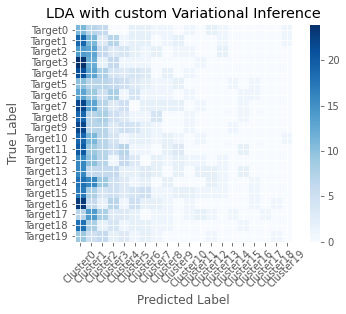

In [ ]:
clusterNames = ["Cluster%d" % i for i in range(20)]
targetNames = ["Target%d" % i for i in range(20)]
cm = metrics.confusion_matrix(target[:1000], predLabels)
plt.figure()
plot_confusion_matrix(plt, cm[:20, :20],
                       classes=targetNames,
                       clusters=clusterNames,
                       title='LDA with custom Variational Inference')

In [ ]:
print("LDA with custom Variational Inference")
print("Homogeneity", metrics.homogeneity_score(target[:1000], predLabels))
print("Completenesee", metrics.completeness_score(target[:1000], predLabels))
print("Normalized Mutual Information", metrics.normalized_mutual_info_score(target[:1000], predLabels))
print("Purity", purity_score(target[:1000], predLabels))

LDA with custom Variational Inference
Homogeneity 0.06386051774632591
Completenesee 0.08851532148057385
Normalized Mutual Information 0.0741933142014031
Purity 0.106


# Comparison

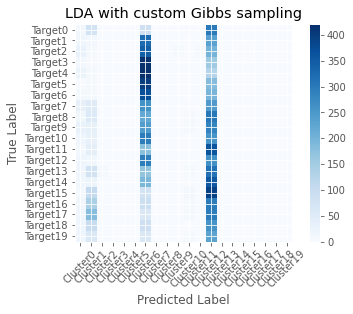

Homogeneity 0.04063416533673405
Completeness 0.11067726730802309
Normalized Mutual Information 0.05944399970583384
Purity 0.09395439278769666


In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/predLabels_Gibbs_custom.pkl','rb')
predLabels = pickle.load(file)
file.close()

clusterNames = ["Cluster%d" % i for i in range(20)]
targetNames = ["Target%d" % i for i in range(20)]
cm = metrics.confusion_matrix(target, predLabels)
plt.figure()
plot_confusion_matrix(plt, cm,
                       classes=targetNames,
                       clusters=clusterNames,
                       title='LDA with custom Gibbs sampling')
plt.show()

print("Homogeneity", metrics.homogeneity_score(target, predLabels))
print("Completeness", metrics.completeness_score(target, predLabels))
print("Normalized Mutual Information", metrics.normalized_mutual_info_score(target, predLabels))
print("Purity", purity_score(target, predLabels))


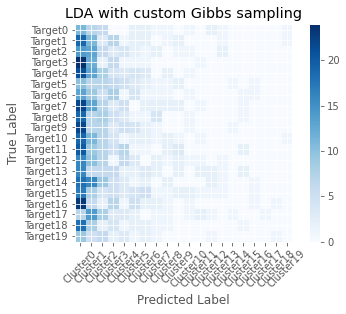

Homogeneity 0.06386051774632591
Completeness 0.08851532148057385
Normalized Mutual Information 0.0741933142014031
Purity 0.106


In [ ]:
file = open('/content/drive/MyDrive/Colab Notebooks/predLabels_VarInf_custom.pkl','rb')
predLabels = pickle.load(file)
file.close()

clusterNames = ["Cluster%d" % i for i in range(20)]
targetNames = ["Target%d" % i for i in range(20)]
cm = metrics.confusion_matrix(target[:1000], predLabels)
plt.figure()
plot_confusion_matrix(plt, cm[:20, :20],
                       classes=targetNames,
                       clusters=clusterNames,
                       title='LDA with custom Gibbs sampling')
plt.show()

print("Homogeneity", metrics.homogeneity_score(target[:1000], predLabels))
print("Completeness", metrics.completeness_score(target[:1000], predLabels))
print("Normalized Mutual Information", metrics.normalized_mutual_info_score(target[:1000], predLabels))
print("Purity", purity_score(target[:1000], predLabels))